In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import arviz as az
import pingouin as pg
import sys

In [2]:
# load file with plotting stlye definitions
sys.path.append('../')
plt.style.use('plotting_style.mpltstyle')

# Model Comparison
This notebook shows inferred parameter distributions of all models and performs model comparison based on LOO from the ArviZ package.

### Load Posteriors

In [3]:
def load_posteriors(path, filename):
    filename = f'{path}/{filename}'
    with open(filename, 'rb') as f:
        posterior = pd.read_pickle(f)

    return posterior

In [ ]:
# load posteriors -> SELECT RIGHT PATH DEPENDING ON OS!
#path = '/Volumes/T7/Pacman_Pickle' # iOS
path = 'E:Pacman_Pickle/' # Windows

In [ ]:
posteriorsEVM = load_posteriors(path, 'posterior_EVM_empirical.pkl') 
posteriorsEVPM = load_posteriors(path, 'posterior_EVPM_empirical.pkl')
posteriorsEVPBM = load_posteriors(path, 'posterior_EVPBM_empirical.pkl')
posteriorsEVPRM = load_posteriors(path, 'posterior_EVPRM_empirical.pkl')
# posteriorsEVPRMv2 = load_posteriors(path, 'posterior_EVPRM_v2_empirical.pkl')

## Calculate LOOs

In [ ]:
# deviance scale (for LOO model comparison)
loosEVM = az.loo(posteriorsEVM, scale='deviance', pointwise=True)
loosEVPM = az.loo(posteriorsEVPM, scale='deviance', pointwise=True)
loosEVPBM = az.loo(posteriorsEVPBM, scale='deviance', pointwise=True)
loosEVPRM = az.loo(posteriorsEVPRM, scale='deviance', pointwise=True)
# loosEVPRMv2 = az.loo(posteriorsEVPRMv2, scale='deviance', pointwise=True)

In [110]:
# save the LOOs
#f = open('../data_empirical/LOOs.pkl', 'wb')
#pickle.dump((loosEVM, loosEVPM, loosEVPBM, loosEVPRM), f) #, loosEVPRMv2
#f.close()

## Model Comparison Group-Level

In [6]:
# load LOOs
f = open('../data_empirical/LOOs.pkl', 'rb')
loosEVM, loosEVPM, loosEVPBM, loosEVPRM = pd.read_pickle(f) #, loosEVPRMv2
f.close()

In [7]:
# create df with LOOs (incl. SE)
dfModelComparison = pd.DataFrame(index=['EVM', 'EVPM', 'EVPBM', 'EVPRM']) #, 'EVPRM_v2'
dfModelComparison['LOOIC'] = np.array([loosEVM.elpd_loo, loosEVPM.elpd_loo, loosEVPBM.elpd_loo, loosEVPRM.elpd_loo]) #, loosEVPRMv2.elpd_loo])
dfModelComparison['SE'] = np.array([loosEVM.se, loosEVPM.se, loosEVPBM.se, loosEVPRM.se]) #, loosEVPRMv2.se])

# add LOOIC difference of all models compared to winning EVPRM model for nicer plotting
dfModelComparison['delta_LOOIC'] = np.abs(dfModelComparison['LOOIC']-dfModelComparison.iloc[3,0])

In [8]:
dfModelComparison

,LOOIC,SE,delta_LOOIC
EVM,162308.575947,1355.019012,92365.758752
EVPM,74301.956584,1018.948130,4359.139389
EVPBM,73285.863946,983.731043,3343.046752
EVPRM,69942.817195,825.938841,0.000000


### Model Comparison (McElreath Approach)

This approach was suggested by McElreath in Statistical Rethinking (Chapter 7.5) and based on the SE of the LOO differences. ArviZ uses this approach for <code>az.compare</code>.

(see https://learning.oreilly.com/library/view/statistical-rethinking-2nd/9780429639142/xhtml/15_Chapter07.xhtml#sec7_5)

In [114]:
compareDict = {'EVPM':posteriorsEVPM, 'EVPBM':posteriorsEVPBM, 'EVPRM':posteriorsEVPRM, 'EVM':posteriorsEVM} #'EVPRM_v2':posteriorsEVPRMv2,
modelComparison = az.compare(compareDict, scale='deviance')

/Users/Eric/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/Eric/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/Eric/miniconda3/envs/pymc_env

In [115]:
modelComparison

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
EVPRM,0,69942.817195,810.924480,0.000000,6.555192e-01,825.938841,0.000000,True,deviance
EVPBM,1,73285.863946,1054.579899,3343.046752,4.433028e-12,983.731043,382.346319,True,deviance
EVPM,2,74301.956584,772.521729,4359.139389,3.290715e-01,1018.948130,421.925339,True,deviance
EVM,3,162308.575947,371.924369,92365.758752,1.540930e-02,1355.019012,1319.666900,False,deviance


In [116]:
# save (pickle) model comparison result
#f = open('../data_empirical/model_comparison.pkl', 'wb')
#pickle.dump(modelComparison, f)
#f.close()

/Users/Eric/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/Eric/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/Eric/miniconda3/envs/pymc_env

<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_loo (deviance)', ylabel='ranked models'>

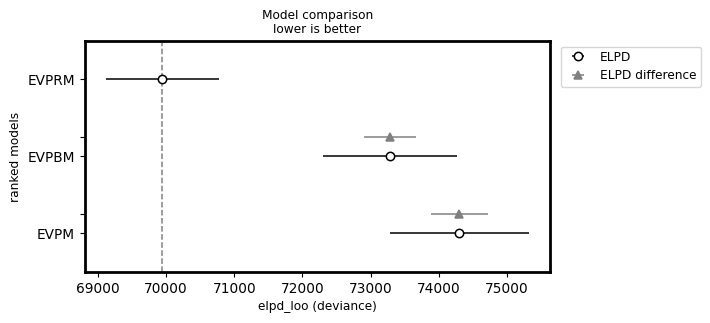

In [117]:
# create plot without EVM (reason to repeat az.compare)
compareDict = {'EVPM':posteriorsEVPM, 'EVPBM':posteriorsEVPBM, 'EVPRM':posteriorsEVPRM,} # 'EVPRM_v2':posteriorsEVPRMv2}
modelComparison = az.compare(compareDict, scale='deviance')
az.plot_compare(modelComparison)

$\to$ no significant difference between EVPRM and EVPRMv2 $\to$ further analyses with EVPRM only, because EVPRM has less free parameters

## Model Comparison Participant-Level

In [7]:
#f = open('../data_empirical/LOOs.pkl', 'rb')
#loosEVM, loosEVPM, loosEVPBM, loosEVPRM = pickle.load(f)
#f.close()

In [13]:
# load empirical data (to know the trial IDs of time out trials)
dfData = pd.read_csv('../inference_data/data_behavior.csv', header=0, usecols=['Participant_ID', 'file_name', 'time_out', 'sequence_ID']) 

# get the participant Idxs of the non time out trials
nonTimeOutIdxs = dfData.loc[dfData['time_out']==0, 'Participant_ID'].to_numpy()

In [10]:
# create df with individual LOOs
# model.loo_i: trial-wise LOOs, excluding time-out trials
dfLOO = pd.DataFrame()

dfLOO['Participant_ID'] = nonTimeOutIdxs
dfLOO['EVM'] = loosEVM.loo_i.to_numpy().flatten()
dfLOO['EVPM'] = loosEVPM.loo_i.to_numpy().flatten()
dfLOO['EVPBM'] = loosEVPBM.loo_i.to_numpy().flatten()
dfLOO['EVPRM'] = loosEVPRM.loo_i.to_numpy().flatten()
# dfLOO['EVPRM_v2'] = loosEVPRMv2.loo_i.to_numpy().flatten()

# calculate sums
dfLOO = dfLOO.groupby(['Participant_ID']).sum() #.reset_index()

# add column with best model fit
bestModelParticipant = dfLOO.idxmin(axis=1)
dfLOO['best_fit'] = bestModelParticipant

# add file name column
dfLOO = pd.merge(dfLOO, dfData[['Participant_ID', 'file_name']].groupby(dfData['Participant_ID']).nth(1).reset_index(), on='Participant_ID')
dfLOO.drop(columns='index', inplace=True)
dfLOO

,Participant_ID,EVM,EVPM,EVPBM,EVPRM,best_fit,file_name
0,0,2403.180354,865.880793,863.100238,865.957918,EVPBM,1635170782.csv
1,1,2205.367658,577.384116,573.241222,577.382066,EVPBM,1635086955.csv
2,2,3380.777419,1809.344016,1809.130683,1475.132897,EVPRM,1635587894.csv
3,3,2229.268938,750.982170,747.323072,767.043619,EVPBM,1635169562.csv
4,4,1691.499682,406.377459,408.104072,410.624857,EVPM,1635250159.csv
...,...,...,...,...,...,...,...
65,65,2241.460656,882.615477,884.905881,888.071702,EVPM,1635702814.csv
66,66,2137.107017,617.515625,615.593564,615.105489,EVPRM,1635431069.csv
67,67,2168.559483,569.777387,552.456146,573.887888,EVPBM,1635254246.csv
68,68,2361.985411,1218.009680,1207.743448,1203.992552,EVPRM,1635198780.csv


In [12]:
#f = open('../data_empirical/results_model_comparison.pkl', 'wb')
#pickle.dump(dfLOO, f)
#f.close()

In [12]:
dfLOO.to_csv('../data_empirical/results_model_comparison_new.csv', index=False)

#### best fit overview

In [18]:
dfLOO['best_fit'].value_counts()

best_fit
EVPM     28
EVPRM    27
EVPBM    15
Name: count, dtype: int64

#### calculate LOO differences for each participant grouped by best fit for plotting

In [19]:
dfLOO = pd.read_pickle('../data_empirical/results_model_comparison.pkl')

In [20]:
dfLOO.sort_values('best_fit', inplace=True)
dfLOO['participant_ID'] = np.arange(len(dfLOO))

In [21]:
dfLoosMelted = dfLOO.melt(id_vars=['participant_ID', 'best_fit'], 
                            value_vars=['EVPM', 'EVPRM', 'EVPBM'], 
                            var_name='model', value_name='LOO')

<Figure size 1000x600 with 0 Axes>

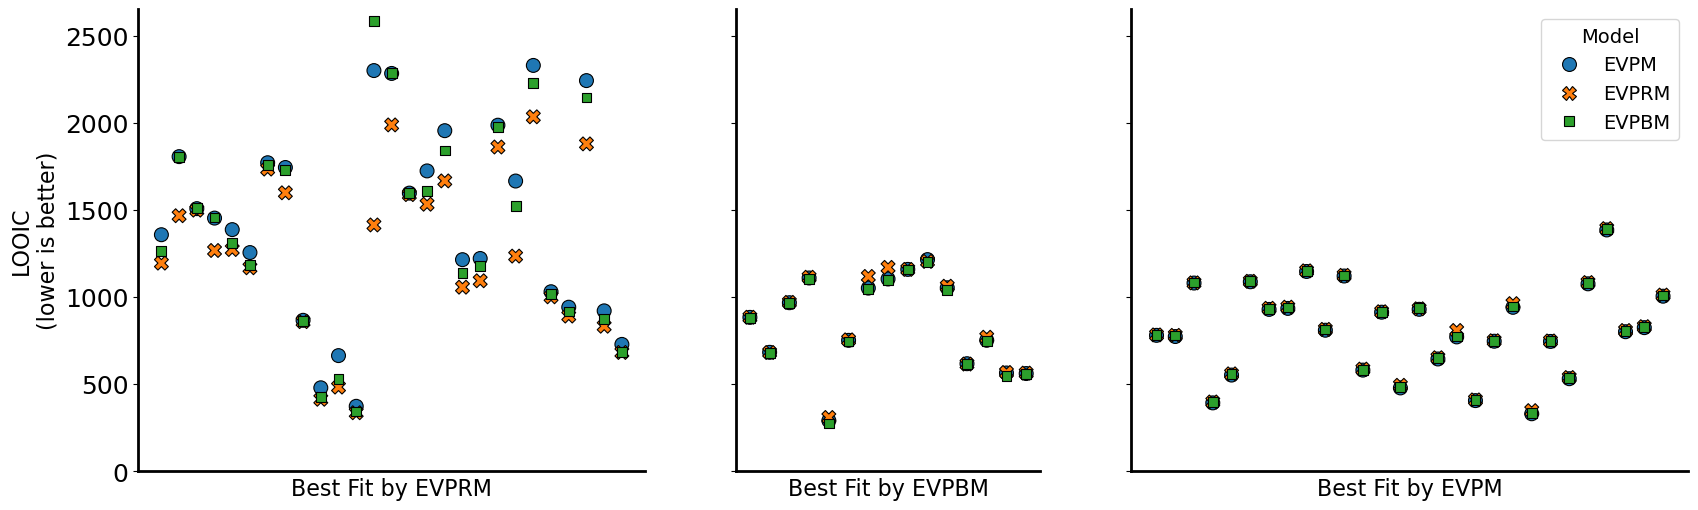

In [ ]:
plt.figure()
fig, axBottom = plt.subplots(1,3, figsize=(20,6), width_ratios=[1,.6,1.1], sharey=True)

# 1) best fit EVPRM
dfPlot = dfLoosMelted.loc[dfLoosMelted['best_fit']=='EVPRM']
sns.scatterplot(data=dfPlot, x='participant_ID', y='LOO', hue='model', style='model', edgecolor='black', s=100, ax=axBottom[0])
axBottom[0].set_ylabel('LOOIC\n(lower is better)', fontsize=16)
axBottom[0].set_xlabel('Best Fit by EVPRM', fontsize=16)
axBottom[0].set_xticks([])
axBottom[0].set_ylim([0, 2650])
axBottom[0].get_legend().remove()
# axBottom[0].text(31, 2700, 'C', fontsize=20, weight='bold')

# 2) best fit EVPBM
dfPlot = dfLoosMelted.loc[dfLoosMelted['best_fit']=='EVPBM']
sns.scatterplot(data=dfPlot, x='participant_ID', y='LOO', style='model', s=100, hue='model', edgecolor='black', ax=axBottom[1])
axBottom[1].set_ylabel('')
axBottom[1].set_xlabel('Best Fit by EVPBM', fontsize=16)
axBottom[1].set_xticks([])
axBottom[1].get_legend().remove()

# 3) best fit EVPM
dfPlot = dfLoosMelted.loc[dfLoosMelted['best_fit']=='EVPM']
sns.scatterplot(data=dfPlot, x='participant_ID', y='LOO', style=dfPlot['model'], hue=dfPlot['model'], s=100, edgecolor='black', ax=axBottom[2]) #.map(legendMap)
axBottom[2].set_ylabel('')
axBottom[2].set_xlabel('Best Fit by EVPM', fontsize=16)
axBottom[2].set_xticks([])
axBottom[2].legend(title='Model', fontsize=14, title_fontsize=14)

#plt.savefig('../figures/model_comparison_axis_0.svg', format='svg')

sns.despine()
plt.show()

# Create table with fitted parameters

In [26]:
dfInference = pd.read_pickle('../data_empirical/inferred_parameters.pkl')

In [23]:
def add_inferred_parameters(df, posterior, modelName, parameters):
    # loop over parameters
    for p in parameters:
        parameterValues = az.summary(posterior, var_names=[p]) # calculate means and SDs

        # add both to existing df
        df[f'{modelName}_{p}_mean'] = parameterValues['mean'].to_numpy()
        df[f'{modelName}_{p}_sd'] = parameterValues['sd'].to_numpy()
    
    return df

In [ ]:
dfInference = pd.DataFrame()
dfInference = add_inferred_parameters(dfInference, posteriorsEVM, 'EVM', ['beta'])
dfInference = add_inferred_parameters(dfInference, posteriorsEVPM, 'EVPM', ['beta', 'R0'])
dfInference = add_inferred_parameters(dfInference, posteriorsEVPBM, 'EVPBM', ['beta', 'R0', 'bias'])
dfInference = add_inferred_parameters(dfInference, posteriorsEVPRM, 'EVPRM', ['beta', 'R0', 'h'])
#dfInference = add_inferred_parameters(dfInference, posteriorsEVPRMv2, 'EVPRM_v2', ['beta', 'R0', 'h', 'h_DAS'])

In [28]:
# add best fitting model and p(DAS)
dfInference['best_fit'] = bestModelParticipant

In [29]:
IdxDAS = 4
dfData['DAS'] = np.where(dfData['sequence_ID']==IdxDAS, 1, 0)
dfInference['p(DAS)'] = dfData['DAS'].groupby(dfData['Participant_ID']).mean()

In [34]:
dfInference.to_pickle('../data_empirical/inferred_parameters.pkl')

### Look at EVPRM parameter distributions depending on best fit

C:\Users\s3090986\AppData\Local\Temp\ipykernel_6556\3783747460.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


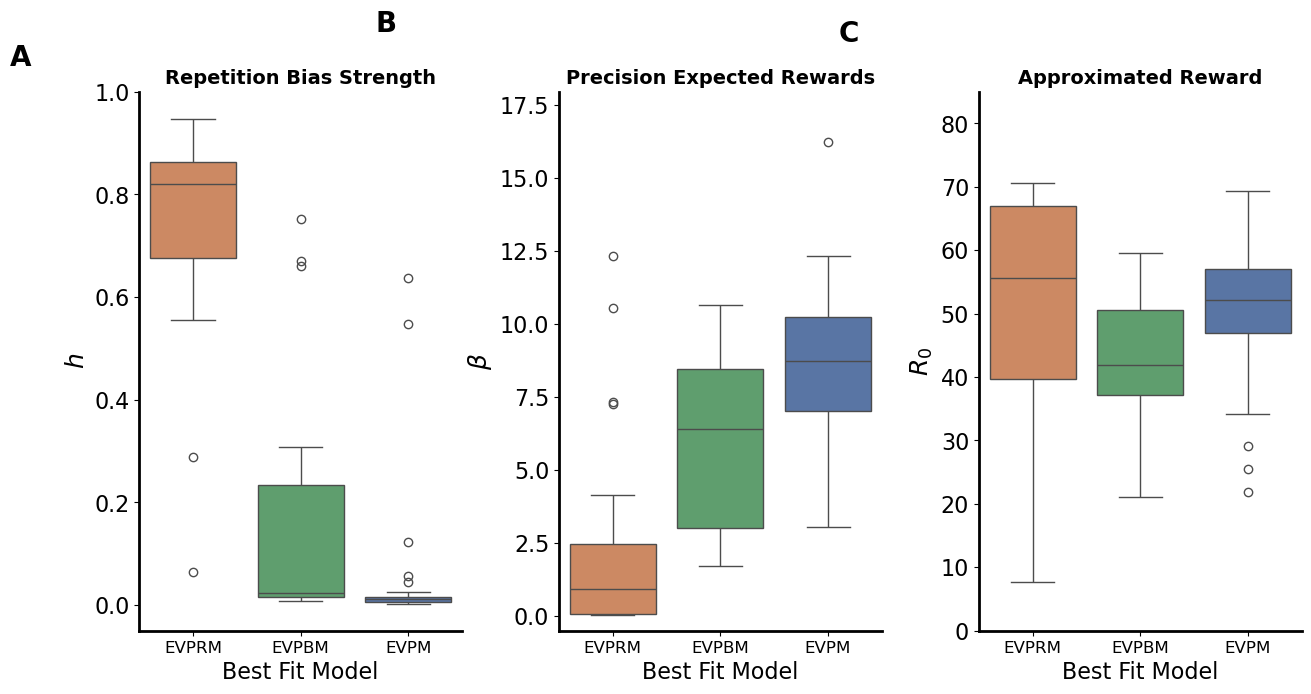

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,7), gridspec_kw={'wspace':.3})

colorMap = sns.color_palette("deep")
colors = [colorMap[1], colorMap[2], colorMap[0]]

# repetition bias h
sns.boxplot(data=dfInference.sort_values('EVPRM_h_mean', ascending=False), 
            x='best_fit', 
            y='EVPRM_h_mean', 
            hue='best_fit', 
            palette=colors,
            ax=axs[0]) #legend=False,
axs[0].set_title(r'Repetition Bias Strength', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Best Fit Model', fontsize=16)
axs[0].set_ylabel(r'$h$', fontsize=18)
#axs[0].get_legend().remove()
axs[0].set_ylim([-.05,1])
axs[0].text(-1.7, 1.05, 'A', fontsize=20, weight='bold')

# precision on expected rewards beta
sns.boxplot(data=dfInference.sort_values('EVPRM_h_mean', ascending=False), 
            x='best_fit', 
            y='EVPRM_beta_mean', 
            hue='best_fit', 
            palette=colors,
            ax=axs[1])
axs[1].set_title(r'Precision Expected Rewards', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Best Fit Model', fontsize=16)
axs[1].set_ylabel(r'$\beta$', fontsize=18)
#axs[1].get_legend().remove()
axs[1].set_ylim([-.5,17.95])
axs[1].text(-2.2, 20, 'B', fontsize=20, weight='bold')

# approximated reward R0
sns.boxplot(data=dfInference.sort_values('EVPRM_h_mean', ascending=False), 
            x='best_fit', 
            y='EVPRM_R0_mean', 
            hue='best_fit', 
            palette=colors, 
            ax=axs[2])
axs[2].set_title(r'Approximated Reward', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Best Fit Model', fontsize=16)
axs[2].set_ylabel(r'$R_0$', fontsize=18)
#axs[2].get_legend().remove()
axs[2].set_ylim([0,85])
axs[2].text(-1.8, 92.8, 'C', fontsize=20, weight='bold')

for ax in [axs[0], axs[1], axs[2]]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=16)

sns.despine()
plt.tight_layout()

#plt.savefig('../figures/parameters_by_best_fit.svg', format='svg')

plt.show()

#### Calculate statistics for this figure
Test for each parameter, if participants have different parameter values depending on best fitting model.

In [11]:
# load data
f = open('../data_empirical/inferred_parameters.pkl', 'rb')
dfInference = pickle.load(f)
f.close()

In [ ]:
# samnity check
dfInference['best_fit'].value_counts()

best_fit
EVPM     28
EVPRM    27
EVPBM    15
Name: count, dtype: int64

In [12]:
dfInference

,EVM_beta_mean,EVM_beta_sd,EVPM_beta_mean,EVPM_beta_sd,EVPM_R0_mean,EVPM_R0_sd,EVPBM_beta_mean,EVPBM_beta_sd,EVPBM_R0_mean,EVPBM_R0_sd,EVPBM_bias_mean,EVPBM_bias_sd,EVPRM_beta_mean,EVPRM_beta_sd,EVPRM_R0_mean,EVPRM_R0_sd,EVPRM_h_mean,EVPRM_h_sd,best_fit,p(DAS)
0,1.695,0.197,10.488,0.940,56.842,2.253,10.433,0.915,58.780,2.260,4.958,1.535,10.555,0.928,59.575,2.285,0.014,0.007,EVPBM,0.556250
1,2.365,0.236,7.334,0.678,39.843,2.634,7.468,0.723,43.802,3.005,8.990,2.483,7.729,0.791,47.418,3.540,0.034,0.024,EVPBM,0.750000
2,0.101,0.050,0.782,0.043,2.478,0.469,0.727,0.042,3.653,0.755,134.177,37.511,0.032,0.013,69.177,9.860,0.927,0.038,EVPRM,0.387500
3,2.361,0.233,3.351,0.246,18.276,2.023,3.174,0.248,20.234,2.329,19.860,6.531,3.153,0.264,21.135,2.607,0.016,0.034,EVPBM,0.756250
4,5.636,0.419,10.715,0.964,48.331,2.238,10.790,0.985,50.259,2.368,3.907,1.493,11.123,1.035,51.585,2.485,0.013,0.007,EVPM,0.684375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2.562,0.234,9.590,0.825,55.523,2.344,9.445,0.814,56.729,2.444,3.878,1.534,9.647,0.831,58.124,2.426,0.012,0.006,EVPM,0.518750
66,2.397,0.231,6.632,0.559,36.430,2.419,6.400,0.588,38.626,2.752,8.807,2.737,6.396,0.622,41.982,3.115,0.030,0.016,EVPBM,0.753125
67,2.387,0.230,6.475,0.564,34.997,2.480,6.447,0.617,40.854,3.089,15.920,3.452,6.637,0.694,47.742,6.209,0.159,0.186,EVPBM,0.784375
68,1.849,0.201,3.222,0.246,23.537,2.295,2.947,0.236,25.206,2.510,24.802,6.712,2.849,0.251,25.953,2.670,0.022,0.008,EVPBM,0.587500


In [13]:
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

In [ ]:
def eta_square_kruskal(H, k, N):
    return (H-k+1)/(N-k)

In [ ]:
parameterNames = ['h', 'beta', 'R0']
modelNames = ['EVPRM', 'EVPBM', 'EVPM'] 

N = 70
k = 3

# loop over parameters
for param in parameterNames:
    print(f'{param}:')
    # select corresponding data
    df = dfInference.loc[:, ['best_fit', f'EVPRM_{param}_mean']]

    # test for normality with Shapiro-Wilk (p<.05 -> no assumption of normality)
    print('Shapiro-Wilk test for normality')
    for m in modelNames:
        stat, p = shapiro(df.loc[df['best_fit']==m, f'EVPRM_{param}_mean'])
        print(f'Model {m}: stat={np.round(stat, 2)} p={np.round(p,3)}')

    # test for equal variances with Levene (p<.05 -> no assumption of homogene variances)
    dataLevene = [ df.loc[df['best_fit']==m, f'EVPRM_{param}_mean'] for m in modelNames ]
    stat, p = levene(*dataLevene, center='mean')
    print(f'\nLevene test: stat={np.round(stat, 2)} p={np.round(p, 3)}')

    # perform Kruskal-Wallis
    stat, p = kruskal(*dataLevene)
    print(f'\nKruskal-Wallis-Test for {param}: H={np.round(stat, 2)}, p={np.round(p, 4)}, eta2={np.round(eta_square_kruskal(stat, k, N),3)}\n')

    print(f'Conover Post-hoc:\n{sp.posthoc_conover(dataLevene)}\n')


h:
Shapiro-Wilk test for normality
Model EVPRM: stat=0.79 p=0.0
Model EVPBM: stat=0.65 p=0.0
Model EVPM: stat=0.38 p=0.0

Levene test: stat=5.07 p=0.009

Kruskal-Wallis-Test for h: H=47.66, p=0.0, eta2=0.681

Conover Post-hoc:
              1             2             3
1  1.000000e+00  1.417172e-08  1.343377e-18
2  1.417172e-08  1.000000e+00  3.758177e-04
3  1.343377e-18  3.758177e-04  1.000000e+00

beta:
Shapiro-Wilk test for normality
Model EVPRM: stat=0.69 p=0.0
Model EVPBM: stat=0.91 p=0.123
Model EVPM: stat=0.96 p=0.314

Levene test: stat=0.37 p=0.69

Kruskal-Wallis-Test for beta: H=31.61, p=0.0, eta2=0.442

Conover Post-hoc:
              1         2             3
1  1.000000e+00  0.000224  2.043559e-10
2  2.238607e-04  1.000000  2.005865e-02
3  2.043559e-10  0.020059  1.000000e+00

R0:
Shapiro-Wilk test for normality
Model EVPRM: stat=0.89 p=0.009
Model EVPBM: stat=0.96 p=0.609
Model EVPM: stat=0.91 p=0.023

Levene test: stat=4.86 p=0.011

Kruskal-Wallis-Test for R0: H=6.09, p=

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 27 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.20.0

numpy     : 1.25.2
arviz     : 0.17.1
seaborn   : 0.12.2
pandas    : 2.2.1
matplotlib: 3.8.4
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]

Watermark: 2.3.1

